In [ ]:
!pip install nltk sastrawi scikit-learn gensim pandas numpy wordcloud

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

# Download resource NLTK (jika belum ada)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

print("Library berhasil diimport.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 80.3 MB/s eta 0:00:00
Library berhasil diimport.


In [ ]:
#load data
df_reviews = pd.read_csv('dataset_stella_sora_original.csv', engine='python', on_bad_lines='warn')
df_reviews.head()

,username,rating,text,date,thumbsUp,replyContent,replyDate,translated_text,clean_text
0,Pengguna Google,5,bagus ROUGEKILL,2025-10-27 16:47:42,0,NaN,NaN,bagus ROUGEKILL,bagus ROUGEKILL
1,Pengguna Google,5,game keren udah ga kikir,2025-10-27 16:24:45,0,NaN,NaN,game keren udah ga kikir,game keren udah ga kikir
2,Pengguna Google,5,bagus,2025-10-27 16:11:57,0,NaN,NaN,bagus,bagus
3,Pengguna Google,1,akhirnya berbenah 🤏,2025-10-27 16:08:43,0,NaN,NaN,akhirnya berbenah 🤏,akhirnya berbenah 🤏
4,Pengguna Google,4,"gacha mahal, kontrol agak ngelag UI, gameplay,...",2025-10-27 15:55:27,0,NaN,NaN,"gacha mahal, kontrol agak ngelag UI, gameplay,...","gacha mahal, kontrol agak ngelag UI, gameplay,..."


In [ ]:
#cleaning
print(f"Jumlah data sebelum filtering: {len(df_reviews)}")
df_reviews = df_reviews[df_reviews['text'].notna()]
print(f"Setelah hapus text None: {len(df_reviews)}")
df_reviews = df_reviews[df_reviews['clean_text'].str.len() > 2]
print(f"Setelah hapus text < 5 karakter: {len(df_reviews)}")
df_reviews = df_reviews[df_reviews['clean_text'].str.strip() != '']
print(f"Setelah hapus text kosong: {len(df_reviews)}")

print(f"\nTotal data yang dihapus: {15000 - len(df_reviews)}")
print(f"Total data final: {len(df_reviews)}")

Jumlah data sebelum filtering: 15000
Setelah hapus text None: 15000
Setelah hapus text < 5 karakter: 14929
Setelah hapus text kosong: 14929

Total data yang dihapus: 71
Total data final: 14929


In [ ]:
#preprosesing
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def clean_text(text):

    if pd.isna(text):
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = stopword_remover.remove(text)
    text = stemmer.stem(text)

    return text

print("proses 'text'...")
df_reviews['clean_text'] = df_reviews['text'].apply(clean_text)
print("Preprocessing selesai!")

for i in range(5):
    print(f"\n[{i+1}]")
    print(f"Original: {df_reviews.iloc[i]['text'][:100]}...")
    print(f"Cleaned:  {df_reviews.iloc[i]['clean_text'][:100]}...")

proses 'text'...
Preprocessing selesai!

[1]
Original: bagus ROUGEKILL...
Cleaned:  bagus rougekill...

[2]
Original: game keren udah ga kikir...
Cleaned:  game keren udah ga kikir...

[3]
Original: bagus...
Cleaned:  bagus...

[4]
Original: akhirnya berbenah 🤏...
Cleaned:  akhir benah...

[5]
Original: gacha mahal, kontrol agak ngelag UI, gameplay, animasi, skill, desain, pergerakan, tampilan udah bag...
Cleaned:  gacha mahal kontrol ngelag ui gameplay animasi skill desain gera tampil udah bagus...


In [ ]:
#labeling
def label_sentiment(rating):
    if rating <= 2:
        return 'Negatif'
    elif rating == 3:
        return 'Netral'
    else:
        return 'Positif'

df_reviews['sentiment'] = df_reviews['rating'].apply(label_sentiment)

sentiment_counts = df_reviews['sentiment'].value_counts()
print(sentiment_counts)

sentiment_pct = df_reviews['sentiment'].value_counts(normalize=True) * 100
for label, pct in sentiment_pct.items():
    print(f"{label}: {pct:.2f}%")

sentiment
Negatif    9619
Positif    4730
Netral      580
Name: count, dtype: int64
Negatif: 64.43%
Positif: 31.68%
Netral: 3.89%


In [ ]:
#encoding
X = df_reviews['clean_text']
y = df_reviews['sentiment']

print(f"\nData yang akan digunakan untuk modeling:")
print(f"  X (Features) : kolom 'clean_text' ")
print(f"  y (Target)   : kolom 'sentiment' ")
print(f"  Total sampel : {len(X)}")

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n{'='*70}")
print("Mapping")
print(f"{'='*70}")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y_encoded == i)
    print(f"  {label:8s} → {i}  (jumlah: {count:5d} sampel | {count/len(y_encoded)*100:5.2f}%)")


Data yang akan digunakan untuk modeling:
  X (Features) : kolom 'clean_text' 
  y (Target)   : kolom 'sentiment' 
  Total sampel : 14929

Mapping
  Negatif  → 0  (jumlah:  9619 sampel | 64.43%)
  Netral   → 1  (jumlah:   580 sampel |  3.89%)
  Positif  → 2  (jumlah:  4730 sampel | 31.68%)


In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X, y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded
)

print(f"\nPembagian Data:")
print(f"  Training: {len(X_train_3)} samples ({len(X_train_3)/len(X)*100:.1f}%)")
print(f"  Testing:  {len(X_test_3)} samples ({len(X_test_3)/len(X)*100:.1f}%)")


print("\nMelakukan TF-IDF Vectorization...")
tfidf_vectorizer_3 = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
) # Added the missing closing parenthesis

X_train_tfidf_3 = tfidf_vectorizer_3.fit_transform(X_train_3)
X_test_tfidf_3 = tfidf_vectorizer_3.transform(X_test_3)

print(f"Shape X_train_tfidf_3: {X_train_tfidf_3.shape}")
print(f"Shape X_test_tfidf_3: {X_test_tfidf_3.shape}")


print("\nMelatih model Random Forest...")
model_rf_3 = RandomForestClassifier(
    n_estimators=200,
    max_depth=50,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

model_rf_3.fit(X_train_tfidf_3, y_train_3)
print("selesai!")


y_train_pred_3 = model_rf_3.predict(X_train_tfidf_3)
y_test_pred_3 = model_rf_3.predict(X_test_tfidf_3)

train_acc_3 = accuracy_score(y_train_3, y_train_pred_3)
test_acc_3 = accuracy_score(y_test_3, y_test_pred_3)

print(f"Akurasi Training: {train_acc_3:.4f}")
print(f"Akurasi Testing:  {test_acc_3:.4f}")

skema3_results = {
    'skema': 'Skema 3',
    'model': 'Random Forest',
    'feature': 'TF-IDF',
    'split': '70/30',
    'train_acc': train_acc_3,
    'test_acc': test_acc_3
}

print("\n--- Hasil Evaluasi Model Random Forest ---")

# Menggunakan model_rf_3 yang sudah dilatih sebelumnya
y_test_pred_rf = model_rf_3.predict(X_test_tfidf_3)

print(f"Accuracy: {accuracy_score(y_test_3, y_test_pred_rf):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_3, y_test_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test_3, y_test_pred_rf))


Pembagian Data:
  Training: 10450 samples (70.0%)
  Testing:  4479 samples (30.0%)

Melakukan TF-IDF Vectorization...
Shape X_train_tfidf_3: (10450, 10000)
Shape X_test_tfidf_3: (4479, 10000)

Melatih model Random Forest...
selesai!
Akurasi Training: 0.9198
Akurasi Testing:  0.8656

--- Hasil Evaluasi Model Random Forest ---
Accuracy: 0.8656

Confusion Matrix:
[[2625    6  255]
 [  34  120   20]
 [ 282    5 1132]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2886
           1       0.92      0.69      0.79       174
           2       0.80      0.80      0.80      1419

    accuracy                           0.87      4479
   macro avg       0.87      0.80      0.83      4479
weighted avg       0.87      0.87      0.86      4479



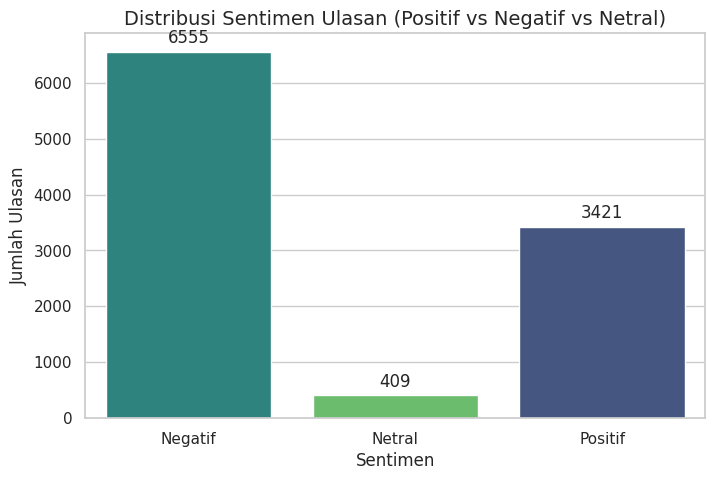

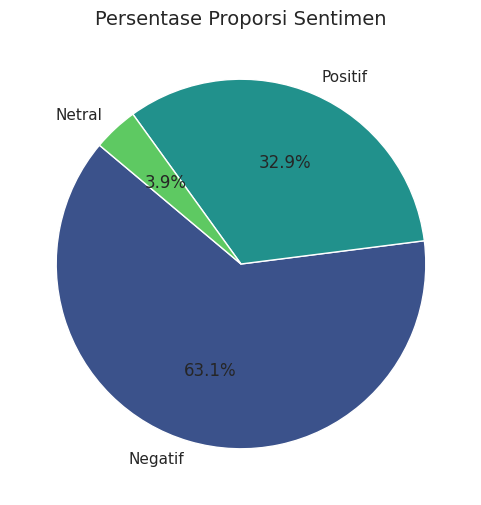

In [ ]:
# Set gaya visualisasi
sns.set(style="whitegrid")

# Tambahkan kolom sentimen berdasarkan rating
def classify_sentiment(rating):
    if rating >= 4:
        return 'Positif'
    elif rating == 3:
        return 'Netral'
    else:
        return 'Negatif'

df_reviews['sentiment'] = df_reviews['rating'].apply(classify_sentiment)

# 1. Visualisasi Distribusi Sentimen (Bar Chart)
plt.figure(figsize=(8, 5))
# Addressing FutureWarning: Passing `palette` without assigning `hue` is deprecated.
# Assign 'sentiment' to `hue` and set `legend=False` for the same effect.
ax = sns.countplot(x='sentiment', data=df_reviews, hue='sentiment', palette='viridis', order=['Negatif', 'Netral', 'Positif'], legend=False)

# Menambahkan label angka di atas batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Distribusi Sentimen Ulasan (Positif vs Negatif vs Netral)', fontsize=14)
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()

# 2. Visualisasi Persentase (Pie Chart)
plt.figure(figsize=(6, 6))
sentiment_counts = df_reviews['sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', 3))
plt.title('Persentase Proporsi Sentimen', fontsize=14)
plt.show()

Generating Word Cloud for Positive Reviews...


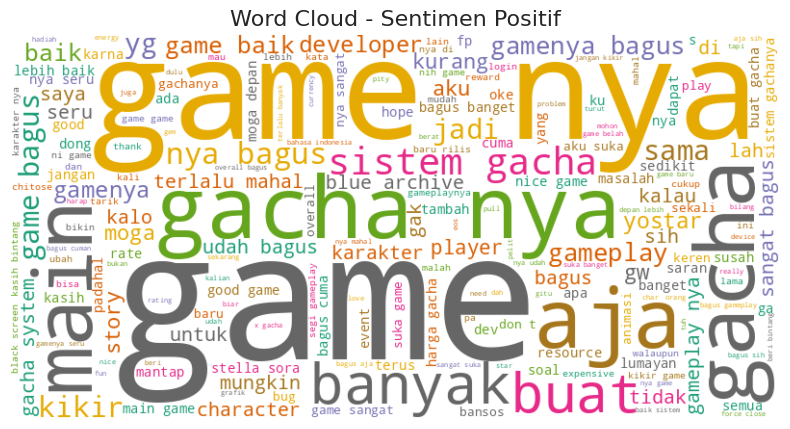

Generating Word Cloud for Negative Reviews...


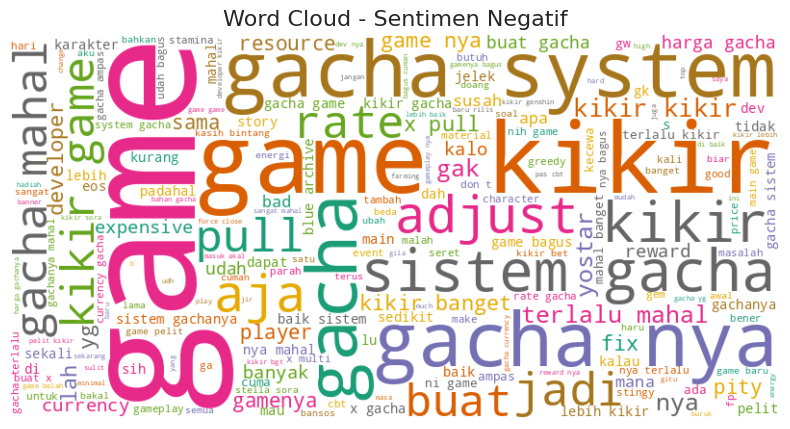

In [ ]:
# Fungsi untuk membuat Word Cloud
def generate_wordcloud(text_data, title):
    all_text = ' '.join(text_data.astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').generate(all_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Word Cloud untuk Sentimen Positif
print("Generating Word Cloud for Positive Reviews...")
df_positif = df_reviews[df_reviews['sentiment'] == 'Positif']
generate_wordcloud(df_positif['clean_text'], 'Word Cloud - Sentimen Positif')

# Word Cloud untuk Sentimen Negatif
print("Generating Word Cloud for Negative Reviews...")
df_negatif = df_reviews[df_reviews['sentiment'] == 'Negatif']
generate_wordcloud(df_negatif['clean_text'], 'Word Cloud - Sentimen Negatif')

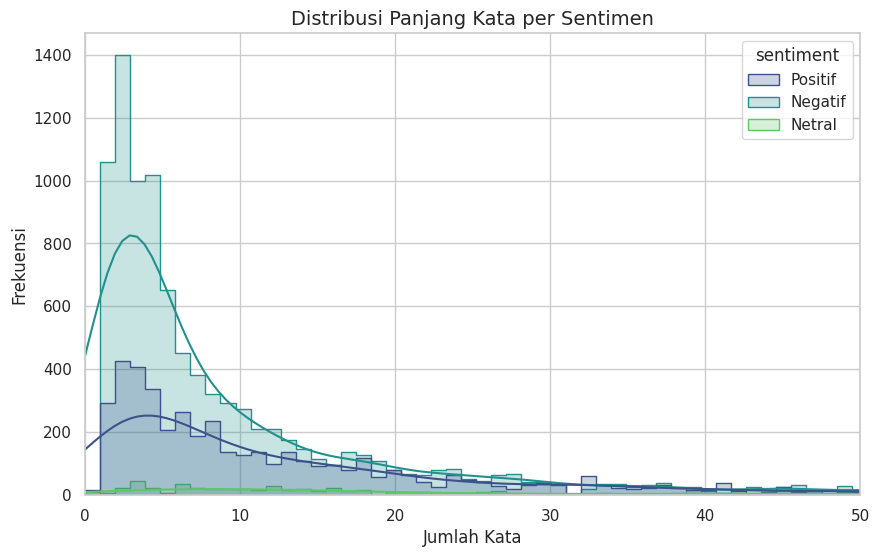

In [ ]:
# Hitung jumlah kata per ulasan
df_reviews['word_count'] = df_reviews['clean_text'].apply(lambda x: len(str(x).split()))

# Plot Histogram Distribusi Jumlah Kata
plt.figure(figsize=(10, 6))
sns.histplot(data=df_reviews, x='word_count', hue='sentiment', kde=True, element="step", palette='viridis')
plt.title('Distribusi Panjang Kata per Sentimen', fontsize=14)
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.xlim(0, 50) # Membatasi tampilan x-axis agar tidak terlalu panjang (bisa disesuaikan)
plt.show()

In [ ]:
!pip install pipreqs
!jupyter nbconvert --to script model.ipynb
!pipreqs . --force

print("\n--- Selesai! ---")
print("File requirements.txt telah dibuat atau diperbarui.")

[NbConvertApp] WARNING | pattern 'model.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execu